In [1]:
import numpy as np
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import torch
import pickle
# set here the directory of the logged folder
PROJECT_ROOT_DIR = Path().resolve().parents[0]

In [4]:
!pwd

/Users/Boss/di_lab_project/di-lab/reports/homo/deep_2_model_2018_12_05_11_50


In [6]:
import sys

In [8]:
sys.path.append('/Users/Boss/di_lab_project/di-lab/src/')

In [11]:
data_set = 'homo'
logger_folder = 'deep_2_model_2018_12_05_10_33'#'deep_2_model_2018_12_04_13_19'
os.chdir(str(PROJECT_ROOT_DIR) + '/reports' + '/' + data_set + '/' + logger_folder)
# import here the correct model file and the correct class name
import models.model_superclass as shallow
#as cnn_skipC_model
from data.data_loader import ProcessData
import logger.visualization as vis
with open('config.json', 'r') as file:
    json_dict = json.load(file)

## Choose up to 2 certain images to display from final model
### You can specify another folder here if you like, but the default should be restored

(28, 401, 401)
(28, 401, 401)
(28, 401, 401)
(28, 401, 401)


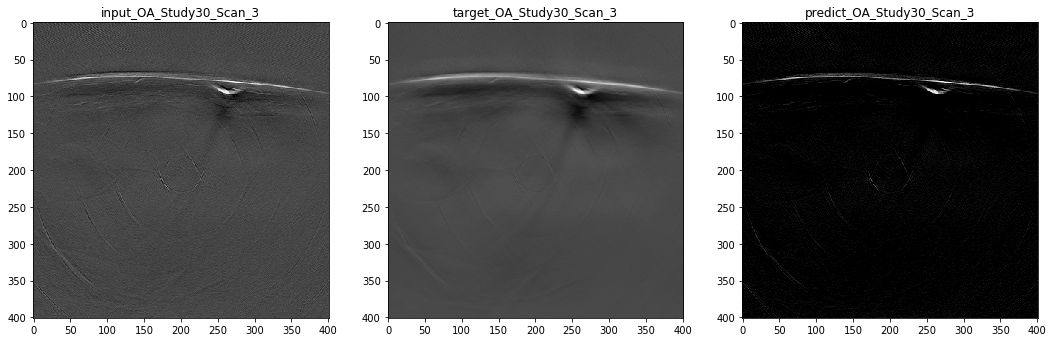

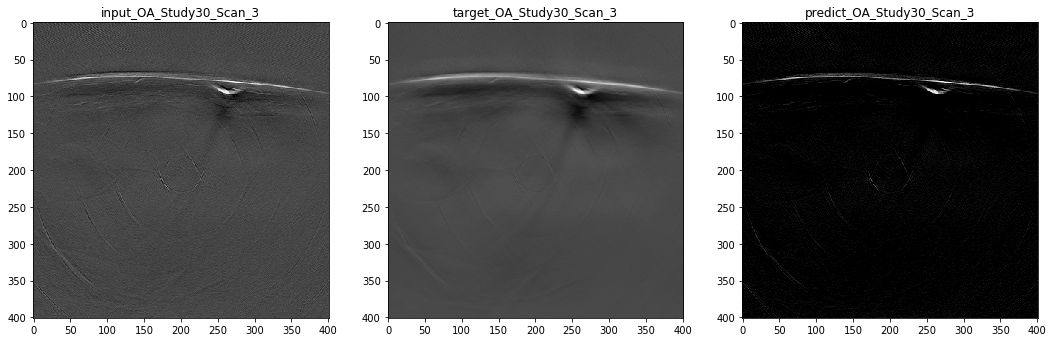

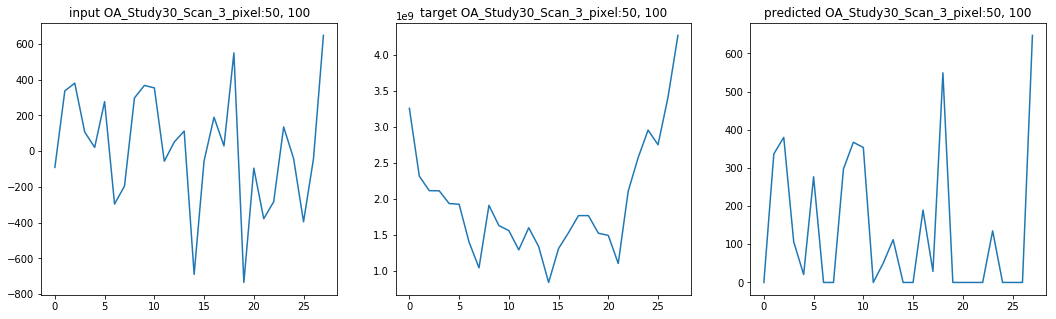

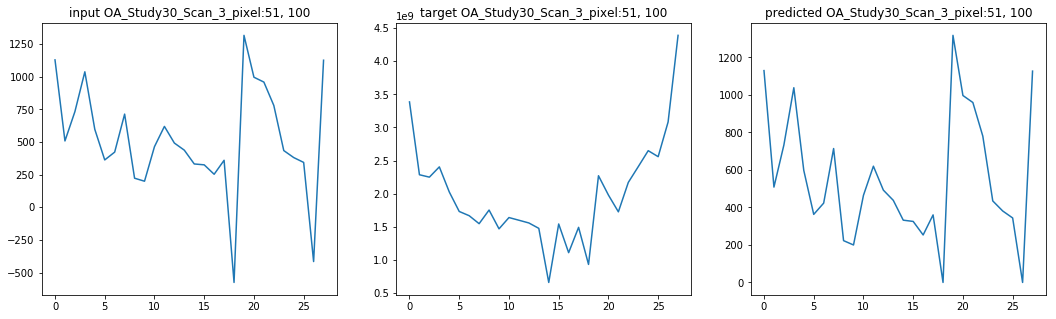

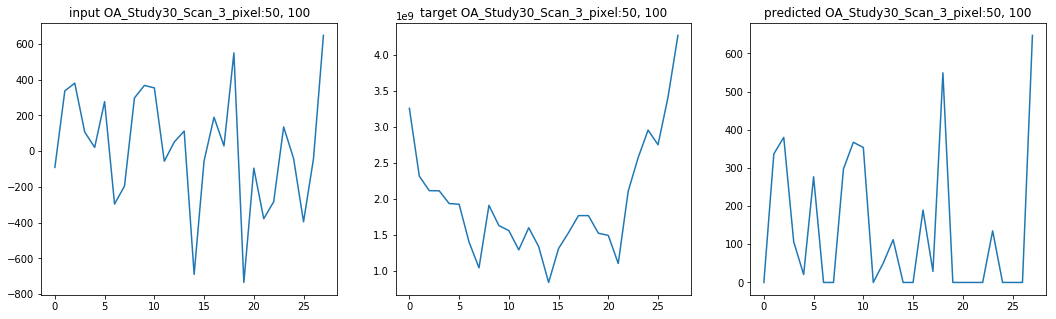

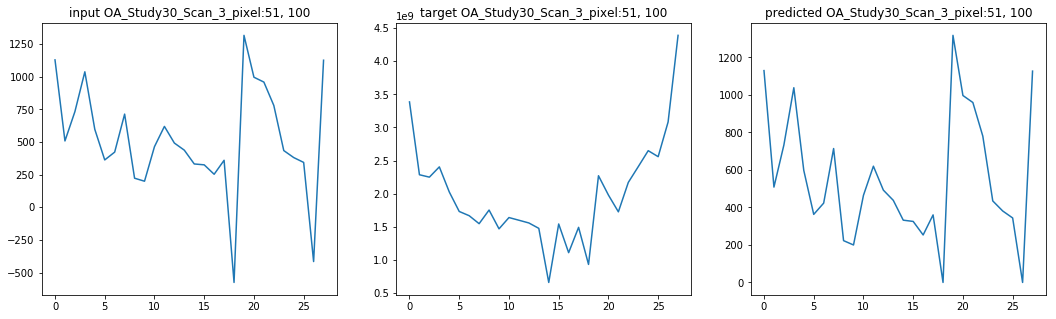

In [13]:
prediction_folder1 = 'predictionsfinal'  # default: 'predictionsfinal'
pred_type1 = 'val'  # default: 'val'
read_folder1 = prediction_folder1 + '/' + pred_type1
num_file1 = 0  # default: 0
plot_channel1 = 0  # default: 0
file_name1 = os.listdir(read_folder1)[num_file1]

input_im1, target_im1, predict_im1 = vis.load_file_to_numpy(read_folder1 + '/' + file_name1)

vis.plot_channel(input_im1, target_im1, predict_im1, name=file_name1, channel=plot_channel1)

prediction_folder2 = 'predictionsfinal'  # default: 'predictionsfinal'
pred_type2 = 'train'  # default: 'train'
read_folder2 = prediction_folder2 + '/' + pred_type2
num_file2 = 0  # default: 0
plot_channel2 = 0  # default: 0
file_name2 = os.listdir(read_folder2)[num_file2]

input_im2, target_im2, predict_im2 = vis.load_file_to_numpy(read_folder2 + '/' + file_name2)

vis.plot_channel(input_im2, target_im2, predict_im2, name=file_name2, channel=plot_channel2)

if json_dict['image_type'] == 'OA':
    vis.plot_oa_spectra(input_im1, target_im1, predict_im1, x=50, y=100, name=file_name1, figsize=(18, 5))
    
    vis.plot_oa_spectra(input_im2, target_im2, predict_im2, x=50, y=100, name=file_name2, figsize=(18, 5))



## Display all saved images in for all models

In [14]:
# read and display saved predicitons and to compare them
list_predictions = [s for s in os.listdir() if 'predictions' in s]
print(list_predictions)
for folder in list_predictions:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-14-c7e58bbcda87>, line 5)

In [21]:
# specify comparison file
read_file = ( '/home/sunita/IDP/Code/Repo/di-lab' + 
            '/data/homo/processed/processed_all/optoacoustic/OA_Study26_Scan_16')

#load test files

#load config.json file
with open('config.json', 'r') as file:
    dict = json.load(file)

# initialize the data_loader
data_loader = ProcessData( train_ratio = dict['train_valid_split'],
                           process_raw_data = (dict['applied_augmentations']['process_raw_data']),
                           data_type = (dict['applied_augmentations']['data_type']),
                           image_type = (dict['applied_augmentations']['image_type']),
                           do_augment = (dict['applied_augmentations']['do_augment']),
                           add_augment = (dict['applied_augmentations']['add_augment']),
                           do_flip = (dict['applied_augmentations']['do_flip']),
                           do_blur = (dict['applied_augmentations']['do_blur']),
                           do_deform = (dict['applied_augmentations']['do_deform']),
                           do_crop = (dict['applied_augmentations']['do_crop']),
                           get_scale_center = (dict['applied_augmentations']['get_scale_center']),
                           single_sample = (dict['applied_augmentations']['single_sample']),
                           logger_call=True)

model_name = dict['model_name']

#change name 
model_import_name = model_name + '__epoch_0.pt'


In [22]:
# initialize the model and load saved parametersprint()

the_model = shallow.ImageTranslator(conv_channels=[28, 32, 64, 128, 256], strides=[1, 2, 1, 2], kernels=[(7,7) for i in range(4)], padding=[3,3,3,3])

if torch.cuda.is_available():
    the_model.load_state_dict(torch.load(model_import_name))
else:
    the_model.load_state_dict(torch.load(model_import_name, map_location='cpu'))
# set the state of the model to eval()
the_model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'deep_2_model__epoch_0.pt'

In [ ]:
def plot_channel(im_input, im_target, im_predict):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('input image')
    plt.imshow(im_input[:,:], cmap = 'gray')


    plt.subplot(1,3,2)
    plt.title('target image')
    plt.imshow(im_target[:,:], cmap = 'gray')
    
    plt.subplot(1,3,3)
    plt.title('predict image')
    plt.imshow(im_predict[:,:], cmap = 'gray')
    

In [15]:
def plot_oa_channel(im_input, im_target, im_predict):
    for i in range(2):
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.title('input image channel:' + str(i))
        plt.imshow(im_input[:,:,i], cmap = 'gray')


        plt.subplot(1,3,2)
        plt.title('target image channel:' + str(i))
        plt.imshow(im_target[:,:,i], cmap = 'gray')
    
      
        plt.subplot(1,3,3)
        plt.title('predict image channel:' + str(i))
        plt.imshow(im_predict[:,:,i], cmap = 'gray')

In [16]:
def plot_oa_spectra(im_input, im_target, im_predict, x, y):
    for i in range(2):
        print(im_predict.shape)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title('input image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_input[x+i,y,:])

        plt.subplot(1,3,2)
        plt.title('target image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_target[x+i,y,:])
        
     
        plt.subplot(1,3,3)
        plt.title('predicted image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_predict[x+i,y,:])

In [17]:
scale_params_low, scale_params_high = data_loader.load_params(param_type="scale_params", dir_params='')
mean_image_low, mean_image_high = data_loader.load_params(param_type="mean_images", dir_params='')

NameError: name 'data_loader' is not defined

In [18]:
target_im = data_loader._load_file_to_numpy(full_file_name=read_file, image_sign=data_loader.image_type +'_high')
input_im = data_loader._load_file_to_numpy(full_file_name=read_file, image_sign=data_loader.image_type + '_low')
print(input_im.shape)
np.expand_dims(input_im, axis=0).shape

NameError: name 'data_loader' is not defined

In [19]:
scale_center_X = data_loader.scale_and_center(np.expand_dims(input_im, axis=0), scale_params_low, mean_image_low)

print(scale_center_X.shape)
if data_loader.image_type == 'US':
    scale_center_X = scale_center_X.reshape(scale_center_X.shape[1], scale_center_X.shape[0],
                                        scale_center_X.shape[2], scale_center_X.shape[3])
    
else:
    scale_center_X = np.moveaxis(scale_center_X, [0, 1, 2, 3], [0, 2, 3, 1])
    print(scale_center_X.shape)
    

NameError: name 'data_loader' is not defined

In [20]:
predict_im = the_model(torch.from_numpy(scale_center_X))


NameError: name 'the_model' is not defined

In [12]:
print(predict_im.shape)


torch.Size([1, 28, 401, 401])


In [13]:
predict_new = predict_im.detach().numpy()
predict_new = np.moveaxis(predict_new, [0, 2, 3, 1] , [0, 1, 2, 3])
print(predict_new.shape)
predict_rescaled = data_loader.scale_and_center_reverse(predict_new,
                                                  scale_params_high, mean_image_high)

print(predict_rescaled.shape)

(1, 401, 401, 28)
(1, 401, 401, 28)


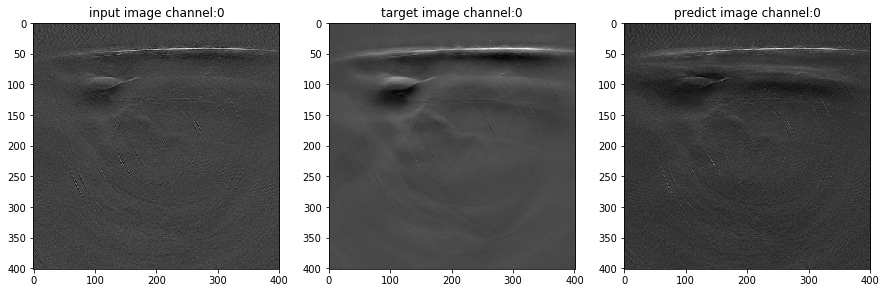

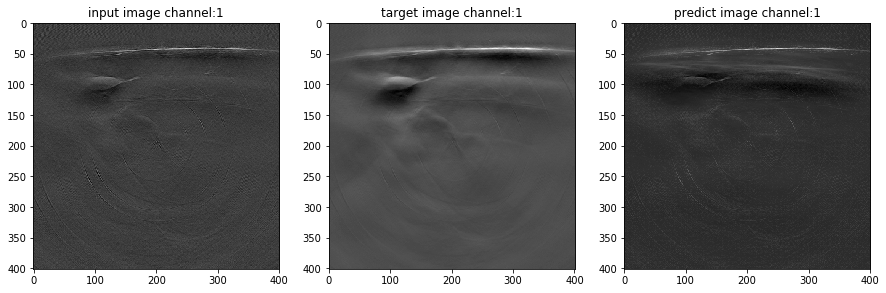

In [104]:
plot_oa_channel(im_input=input_im, im_target=target_im, im_predict=predict_rescaled[0,:,:,:])

(401, 401, 28)
(401, 401, 28)


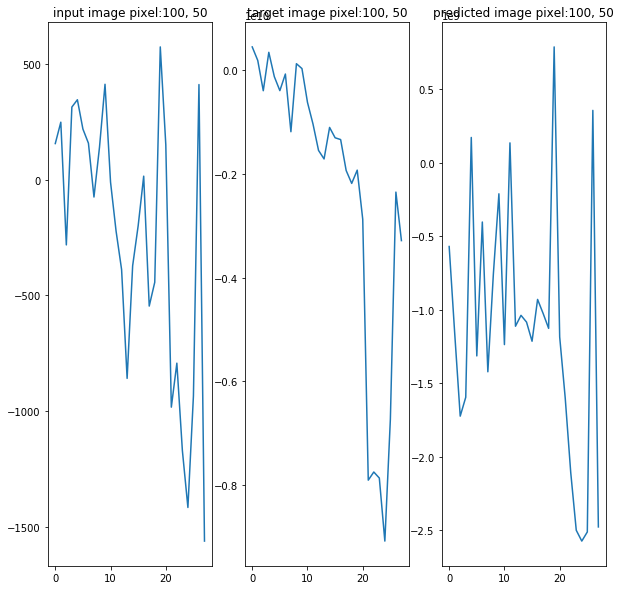

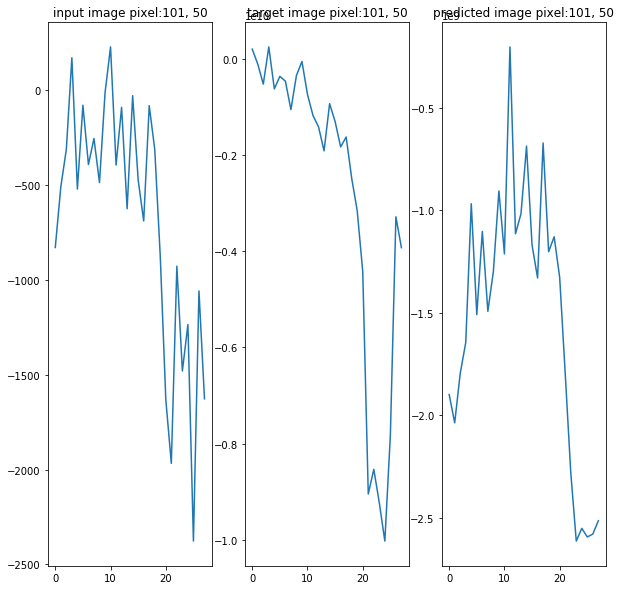

In [105]:
plot_oa_spectra(im_input=input_im, im_target=target_im, im_predict=predict_rescaled[0,:,:,:],x=100,y=50)

[0.14696996 0.10493114 0.04814452 0.01784016 0.01195675 0.01053962
 0.00980415 0.00942063 0.00932123 0.00921472 0.00913974 0.00910036]


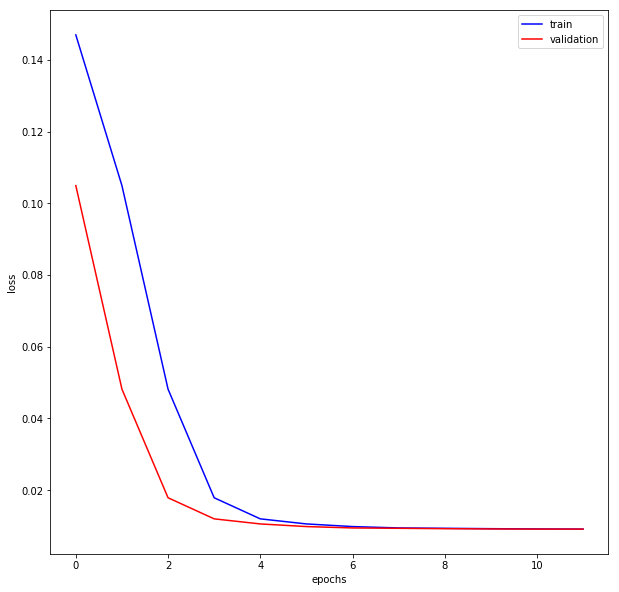

In [111]:
#loss curves
train_loss = np.load(the_model.model_name + '_train_loss.npy')
val_loss = np.load(the_model.model_name + '_validation_loss.npy')

plt.figure(figsize=(10,10))


plt.plot(train_loss,'-b', label='train')
plt.plot(val_loss, '-r', label='validation')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')